# 1.3 Preprocessing and Exporting

In [1]:
import re
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import gensim.downloader
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter, OrderedDict
from gensim.parsing.preprocessing import *

In this section, we'll wrap up our data and convert it to a Tensorflow Dataset, which will later be used by our model, and export some metadata which we'll need to define our model. First, let's reload the data from the CSV file:

In [2]:
all_data = pd.read_csv('../local_data/all_data.csv', header=0, encoding='latin-1')
all_data['genres'] = all_data['genres'].apply(literal_eval)
all_data.head()

,user,movie,rating,timestamp,hour,day,month,gender,age,occupation,zip,city,state,title,genres,movie_year
0,1,1193,5,978300760,0,1,1,1.0,1,10,48067.0,Royal Oak,MI,One Flew Over the Cuckoo's Nest,[Drama],1975
1,2,1193,5,978298413,23,0,12,0.0,56,16,70072.0,Marrero,LA,One Flew Over the Cuckoo's Nest,[Drama],1975
2,12,1193,4,978220179,1,0,12,0.0,25,12,32793.0,Winter Park,FL,One Flew Over the Cuckoo's Nest,[Drama],1975
3,15,1193,4,978199279,20,6,12,0.0,25,7,22903.0,Charlottesville,VA,One Flew Over the Cuckoo's Nest,[Drama],1975
4,17,1193,5,978158471,8,6,12,0.0,50,1,95350.0,Modesto,CA,One Flew Over the Cuckoo's Nest,[Drama],1975


### Train/test split
Before we'll do anything else, let's mark which samples will be used for testing and which for training. We'll use the last 50,000 chronologically as our test set (which is 5% of the data), and the rest will be used as train data.

In [3]:
all_data = all_data.sort_values(by='timestamp', axis=0, ascending=True).reset_index(drop=True)
all_data['is_test'] = all_data.index % 20 == 0
print(f"Number of testing samples: {len(all_data[all_data['is_test']].index)}")

Number of testing samples: 50011


### Exporting the data
Let's begin by preparing the data. There are two features we still need to preprocess first: `title` and `genres`, as we can feed them into a model the way they are. Let's begin with `genres`. We've already split this columns of our `DataFrame` into lists. What we'll do now is convert it to a multi-hot vector, holding `1` fo every genre found in the movie's genres list, and `0` otherwise. 

In [4]:
def genre_as_feature_name(genre): 
    # Here we remove any non-alphanumeric characters from the genre's name, and add a 'genre_' suffix to it
    return 'genre_'+re.sub('[\W_]+', '', genre.lower())

all_genres = all_data['genres'].explode().dropna().unique()
all_data[[genre_as_feature_name(g) for g in all_genres]] = all_data.apply(lambda row: pd.Series({genre_as_feature_name(g): float(g in row['genres']) for g in all_genres}), axis=1)
all_data = all_data.drop('genres', axis=1)
all_data

,user,movie,rating,timestamp,hour,day,month,gender,age,occupation,...,genre_romance,genre_war,genre_filmnoir,genre_mystery,genre_documentary,genre_fantasy,genre_scifi,genre_animation,genre_western,genre_horror
0,6040,858,4,956703932,2,3,4,0.0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6040,593,5,956703954,2,3,4,0.0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6040,2384,4,956703954,2,3,4,0.0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6040,2019,5,956703977,2,3,4,0.0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6040,1961,4,956703977,2,3,4,0.0,25,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,4958,2399,1,1046454338,19,5,2,0.0,18,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1000205,4958,1407,5,1046454443,19,5,2,0.0,18,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000206,4958,2634,3,1046454548,19,5,2,0.0,18,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1000207,4958,3264,4,1046454548,19,5,2,0.0,18,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Next, we need to do some work on the `title`. We'll convert it to numerical features using a pretrained _Word2Vec_ model. If you are unfamiliar with Natural Language Processing (NLP), you can read about this technique [here](https://en.wikipedia.org/wiki/Word2vec), but you can also just copy-paste the following code, as we will not use any more NLP in these projects.

We'll use the pretrained `glove-twitter-25` model, which maps words to a 25-dimensional embedding vector in order to refrain from to many inputs - simply as this is an exercise, and our neural-networks won't be too deep. In reality, larger embeddings can be useful.

We can fetch this model using `gensim` (network connetion is required when running this for the first time).

In [5]:
word2vec = gensim.downloader.load('glove-twitter-25')

Note that this model requires all words to be lower-cased. We'll create a title's embedding by doing the following:

1. Split the title to words
1. For each word, strip punctuation marks, non-alphanumeric characters, remove stopwords and multiple whitespaces, as well as adding spaces between letters and numbers (converting _2Fast 2Furious_ to _2 fast 2 furious_)
1. Map each word to its embedding vector
1. Sum all words embeddings to create the title's embedding


In [6]:
def safe_embbed_word(word, length=25):
    try:
        return word2vec[word.lower()]
    except KeyError:
        return np.zeros(length)
    
def embbed_title(row):
    words = strip_multiple_whitespaces(remove_stopwords(split_alphanum(strip_non_alphanum(strip_punctuation(row['title']))))).split(' ')  # all functions are imported from gensim.parsing.preprocessing
    embs = np.array([safe_embbed_word(w) for w in words])
    return pd.Series({f'title_emb_{i}': v for i,v in enumerate(embs.sum(axis=0))})
    
all_data[[f'title_emb_{i}' for i in range(25)]] = all_data.apply(embbed_title, axis=1)
all_data = all_data.drop('title', axis=1)
all_data.head()

,user,movie,rating,timestamp,hour,day,month,gender,age,occupation,...,title_emb_15,title_emb_16,title_emb_17,title_emb_18,title_emb_19,title_emb_20,title_emb_21,title_emb_22,title_emb_23,title_emb_24
0,6040,858,4,956703932,2,3,4,0.0,25,6,...,-0.430093,0.605320,0.794039,0.092850,0.811670,-1.02820,1.087650,-0.47741,-1.77268,0.17175
1,6040,593,5,956703954,2,3,4,0.0,25,6,...,0.392590,-0.187611,0.298779,0.283710,0.297910,-0.62418,1.348594,0.17822,-2.27917,-0.25669
2,6040,2384,4,956703954,2,3,4,0.0,25,6,...,-0.443910,1.350310,-2.526400,-0.617375,0.513457,-0.28922,1.259290,-0.32954,-0.78366,0.89596
3,6040,2019,5,956703977,2,3,4,0.0,25,6,...,-4.428340,2.198060,0.302161,2.063220,3.737010,-4.68847,2.532940,-0.95960,-5.73041,-0.71771
4,6040,1961,4,956703977,2,3,4,0.0,25,6,...,0.274697,0.838140,0.354366,-0.950417,-0.788934,-0.28553,1.534801,1.26161,0.83066,1.15083


We'll drop the `zip` feature (and `timestamp`, which was only used for train/test split) and then split the dataset to 95% training data and 5% test data, using the `is_test` column we added before. Then we'll save the splitted data as two CSV files, which we'll later transform to Tensorflow Datasets.

In [7]:
all_data = all_data.drop(['zip', 'timestamp'], axis=1)   
test_data = all_data[all_data['is_test']].drop('is_test', axis=1)
train_data = all_data[~all_data['is_test']].drop('is_test', axis=1)

train_data.to_csv('../local_data/train_data.csv', index=False)
test_data.to_csv('../local_data/test_data.csv', index=False)

### Metadata
Our model we'll need some metadata in order to function. Let's go over on what we'll need.

In [8]:
metadata = dict()

Most of the metadata we need to provide the model is the _tokens_ which we would like it to create embeddings for. This basically means all values of non-continuous numeric features. As I find it convenient, I'll also provide it with the values we used to mask missing values in our data, as well as the columns names of our genres and title embedding, so we can group them together.

Let's begin:

In [9]:
metadata['title_emb_size'] = 25  # size of embedding of glove-twitter-25
metadata['string_na'] = 'XX'  # Defined in project 1.1
metadata['genres'] = [genre_as_feature_name(g) for g in all_genres]
metadata['ages'] = all_data['age'].unique().tolist()
metadata['occupations'] = all_data['occupation'].unique().tolist()

We're left with `user`, `movie`, `city` and `state`. But should we let the model learn embeddings for all the possible values? 

Let's take a look at the users activity distribution. This distribution is very common in recommendation systems, and is referred to as the _Long-Tail Distribution_. What we see here is that we have very few users responsible for the majority of traffic, and many many users, each contributing very little. As non-active users have very few data samples, we see no reason in trying to learn embeddings for them. We usually drop these, knowing that if they ever log-in, the system we'll use the embedding for all of them - an embedding known as _OOV_, Out Of Vocabulary, which is the embedding the system uses whenever it encounters a user it has never seen before.

Here we see that of the ~6000 users in this dataset, the 2500 most active ones are responsible for 80% of the traffic. We'll let out model learn embedding only to those, the rest we'll ignore and use OOV whenever needed.

0.7983711404316498

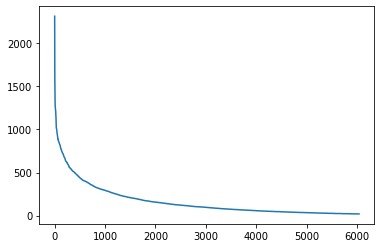

In [10]:
du = OrderedDict()
for k,v in sorted(Counter(all_data['user']).items(), key=lambda item: -item[1]):
    du[k] = v
lu = list(du.values())
plt.plot(range(len(lu)), lu)
sum(lu[:2500])/sum(lu)

In [11]:
metadata['users'] = list(du.keys())[:2500]

We do the same with movies:

0.8047208133500099

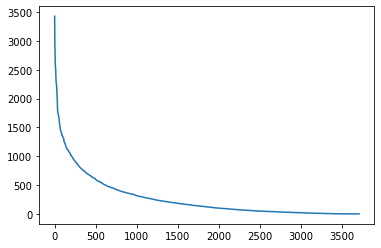

In [12]:
dm = OrderedDict()
for k,v in sorted(Counter(all_data['movie']).items(), key=lambda item: -item[1]):
    dm[k] = v
lm = list(dm.values())
plt.plot(range(len(lm)), lm)
sum(lm[:1200])/sum(lm)

In [13]:
metadata['movies'] = list(dm.keys())[:1200]

And states and cities. Note we remove the missing-value token from the list, as the model will handle it differently.

0.8249759046612609

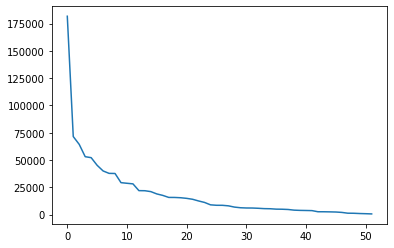

In [14]:
ds = OrderedDict()
for k,v in sorted(Counter(all_data['state']).items(), key=lambda item: -item[1]):
    if k != metadata['string_na']:
        ds[k] = v
ls = [x for x in ds.values() if x != metadata['string_na']]
plt.plot(range(len(ls)), ls)
sum(ls[:20])/sum(ls)

0.8173047974476115

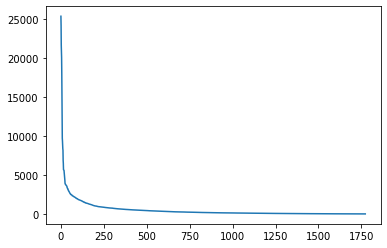

In [15]:
dc = OrderedDict()
for k,v in sorted(Counter(all_data['city']).items(), key=lambda item: -item[1]):
    if k != metadata['string_na']:
        dc[k] = v
lc = [x for x in dc.values() if x != metadata['string_na']]
plt.plot(range(len(lc)), lc)
sum(lc[:500])/sum(lc)

In [16]:
metadata['states'] = list(ds.keys())[:20]
metadata['cities'] = list(dc.keys())[:500]

Finally, we save the metadata to a file:

In [17]:
with open('../local_data/metadata.json', 'w+') as f:
    json.dump(metadata, f)